# Identity-Aware Environmental Study
This notebook evaluates how environmental signals predict yield when the model is provided with **Stock Identity (country_encoded)**, but NO historical yield data.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

df = pd.read_csv('Final_fisheries_dataset.csv')
df = df.rename(columns={'country': 'Stock', 'year': 'Year', 'biomass_relative_to': 'Production'})
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')
df = df.dropna(subset=['Production']).sort_values(['Stock', 'Year'])

# FEATURE ENGINEERING
df['SST_Lag1'] = df.groupby('Stock')['SST'].shift(1)
df['SST_Mean'] = df.groupby('Stock')['SST'].transform('mean')
df['SST_Anomaly'] = df['SST'] - df['SST_Mean']
df['Climate_Fishing_Pressure'] = df['SST'] * df['Trawling_Hours']

df = df.dropna()
features = ['Year', 'country_encoded', 'SST', 'Trawling_Hours', 'SST_Lag1', 'SST_Anomaly', 'Climate_Fishing_Pressure']

X = df[features]
y = df['Production']
print(f'Training Identity-Aware Model on {len(df):,} records.')

Training Identity-Aware Model on 52,906 records.


In [5]:
train_mask = df['Year'] < 2013
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Identity-Aware Environmental R2: {r2_score(y_test, y_pred):.3f}')

Identity-Aware Environmental R2: 0.563


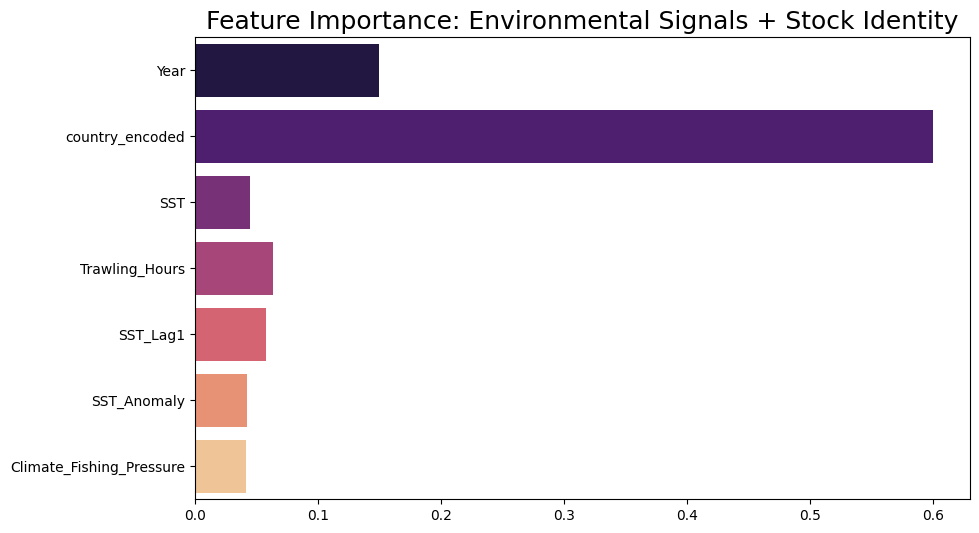

In [6]:
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
# Fixed plotting to avoid FutureWarning
sns.barplot(x=importances, y=features, hue=features, palette='magma', legend=False)
plt.title('Feature Importance: Environmental Signals + Stock Identity', fontsize=18)
plt.show()